In [2]:
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import decode_predictions

TensorFlow 1.x selected.


Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_imgs = np.load('/content/drive/My Drive/Colab Notebooks/data_files/target_images.npy')
train_labels = np.load('/content/drive/My Drive/Colab Notebooks/data_files/target_labels.npy')
test_imgs = np.load('/content/drive/My Drive/Colab Notebooks/data_files/test_images.npy')
test_labels = np.load('/content/drive/My Drive/Colab Notebooks/data_files/test_labels.npy')

print(train_imgs.shape)
print(train_labels[0]) # one-hot-encoded 5 classes 

(65, 224, 224, 3)
[1. 0. 0. 0. 0.]


In [5]:
Dict = ['Hat','Cube','Card','Torch','screw']

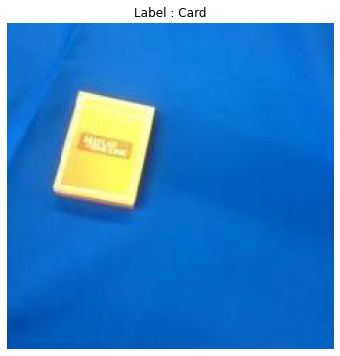

In [6]:
n_train = train_imgs.shape[0]
n_test = test_imgs.shape[0]
idx = np.random.randint(n_train)

plt.figure(figsize = (6,6))
plt.imshow(train_imgs[idx])
plt.title("Label : {}".format(Dict[np.argmax(train_labels[idx])]))
plt.axis('off')
plt.show()

In [7]:
model = VGG16(weights = 'imagenet')

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

553467904/553467096 [==============================] - 12s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 11


40960/35363 [==================================] - 0s 0us/step
1. mosquito_net: 6.94%
2. toilet_tissue: 3.43%
3. Band_Aid: 1.53%
4. envelope: 1.46%
5. shower_curtain: 1.39%


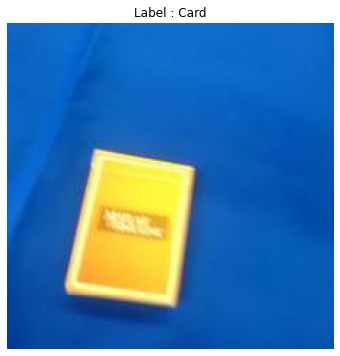

In [8]:
idx = np.random.randint(n_test)
pred = model.predict(test_imgs[idx].reshape(-1, 224, 224, 3))

for (i, (_, label, prob)) in enumerate(decode_predictions(pred)[0]):
    print("{}. {}: {:.2f}%".format(i + 1, label, prob*100))
    
plt.figure(figsize = (6,6))
plt.imshow(train_imgs[idx])
plt.title("Label : {}".format(Dict[np.argmax(train_labels[idx])]))
plt.axis('off')
plt.show()    

In [9]:
vgg16_weights = model.get_weights()

weights = {
    'conv1_1' : tf.constant(vgg16_weights[0]),
    'conv1_2' : tf.constant(vgg16_weights[2]),
    
    'conv2_1' : tf.constant(vgg16_weights[4]),
    'conv2_2' : tf.constant(vgg16_weights[6]),
    
    'conv3_1' : tf.constant(vgg16_weights[8]),
    'conv3_2' : tf.constant(vgg16_weights[10]),
    'conv3_3' : tf.constant(vgg16_weights[12]),
    
    'conv4_1' : tf.constant(vgg16_weights[14]),
    'conv4_2' : tf.constant(vgg16_weights[16]),
    'conv4_3' : tf.constant(vgg16_weights[18]),
    
    'conv5_1' : tf.constant(vgg16_weights[20]),
    'conv5_2' : tf.constant(vgg16_weights[22]),
    'conv5_3' : tf.constant(vgg16_weights[24]),
    
    'fc1' : tf.constant(vgg16_weights[26]),
    'fc2' : tf.constant(vgg16_weights[28]),
    
    # train from scratch
    'output' : tf.Variable(tf.random.normal([4096, 5], stddev = 0.1))
}

biases = {
    'conv1_1' : tf.constant(vgg16_weights[1]),
    'conv1_2' : tf.constant(vgg16_weights[3]),
    
    'conv2_1' : tf.constant(vgg16_weights[5]),
    'conv2_2' : tf.constant(vgg16_weights[7]),
    
    'conv3_1' : tf.constant(vgg16_weights[9]),
    'conv3_2' : tf.constant(vgg16_weights[11]),
    'conv3_3' : tf.constant(vgg16_weights[13]),
    
    'conv4_1' : tf.constant(vgg16_weights[15]),
    'conv4_2' : tf.constant(vgg16_weights[17]),
    'conv4_3' : tf.constant(vgg16_weights[19]),
    
    'conv5_1' : tf.constant(vgg16_weights[21]),
    'conv5_2' : tf.constant(vgg16_weights[23]),
    'conv5_3' : tf.constant(vgg16_weights[25]),
    
    'fc1' : tf.constant(vgg16_weights[27]),
    'fc2' : tf.constant(vgg16_weights[29]),
    
    # train from scratch
    'output' : tf.Variable(tf.random.normal([5], stddev = 0.1))
}

In [10]:
x = tf.placeholder(tf.float32, [None, 224, 224, 3])
y = tf.placeholder(tf.float32, [None, 5])

In [11]:
def transfer(x, weights, biases):
    # First convolution layer
    conv1_1 = tf.nn.conv2d(x, 
                         weights['conv1_1'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv1_1 = tf.nn.relu(tf.add(conv1_1, biases['conv1_1']))
    conv1_2 = tf.nn.conv2d(conv1_1, 
                         weights['conv1_2'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv1_2 = tf.nn.relu(tf.add(conv1_2, biases['conv1_2']))
    maxp1 = tf.nn.max_pool(conv1_2, 
                           ksize = [1, 2, 2, 1], 
                           strides = [1, 2, 2, 1], 
                           padding = 'VALID')

    # Second convolution layer
    conv2_1 = tf.nn.conv2d(maxp1, 
                         weights['conv2_1'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv2_1 = tf.nn.relu(tf.add(conv2_1, biases['conv2_1']))
    conv2_2 = tf.nn.conv2d(conv2_1, 
                         weights['conv2_2'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv2_2= tf.nn.relu(tf.add(conv2_2, biases['conv2_2']))
    maxp2 = tf.nn.max_pool(conv2_2, 
                           ksize = [1, 2, 2, 1], 
                           strides = [1, 2, 2, 1], 
                           padding = 'VALID')

    # third convolution layer
    conv3_1 = tf.nn.conv2d(maxp2, 
                         weights['conv3_1'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv3_1 = tf.nn.relu(tf.add(conv3_1, biases['conv3_1']))
    conv3_2 = tf.nn.conv2d(conv3_1, 
                         weights['conv3_2'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv3_2= tf.nn.relu(tf.add(conv3_2, biases['conv3_2']))
    conv3_3 = tf.nn.conv2d(conv3_2, 
                         weights['conv3_3'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv3_3= tf.nn.relu(tf.add(conv3_3, biases['conv3_3']))
    maxp3 = tf.nn.max_pool(conv3_3, 
                           ksize = [1, 2, 2, 1], 
                           strides = [1, 2, 2, 1], 
                           padding = 'VALID')

    # fourth convolution layer
    conv4_1 = tf.nn.conv2d(maxp3, 
                         weights['conv4_1'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv4_1 = tf.nn.relu(tf.add(conv4_1, biases['conv4_1']))
    conv4_2 = tf.nn.conv2d(conv4_1, 
                         weights['conv4_2'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv4_2= tf.nn.relu(tf.add(conv4_2, biases['conv4_2']))
    conv4_3 = tf.nn.conv2d(conv4_2, 
                         weights['conv4_3'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv4_3= tf.nn.relu(tf.add(conv4_3, biases['conv4_3']))
    maxp4 = tf.nn.max_pool(conv4_3, 
                           ksize = [1, 2, 2, 1], 
                           strides = [1, 2, 2, 1], 
                           padding = 'VALID')

    # fifth convolution layer
    conv5_1 = tf.nn.conv2d(maxp4, 
                         weights['conv5_1'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv5_1 = tf.nn.relu(tf.add(conv5_1, biases['conv5_1']))
    conv5_2 = tf.nn.conv2d(conv5_1, 
                         weights['conv5_2'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv5_2= tf.nn.relu(tf.add(conv5_2, biases['conv5_2']))
    conv5_3 = tf.nn.conv2d(conv5_2, 
                         weights['conv5_3'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv5_3= tf.nn.relu(tf.add(conv5_3, biases['conv5_3']))
    maxp5 = tf.nn.max_pool(conv5_3, 
                           ksize = [1, 2, 2, 1], 
                           strides = [1, 2, 2, 1], 
                           padding = 'VALID')
    
    maxp5 = tf.reshape(maxp5, [-1, 7*7*512])

    # fully connected layer
    fc1 = tf.add(tf.matmul(maxp5, weights['fc1']), biases['fc1'])
    fc1 = tf.nn.relu(fc1)
    
    fc2 = tf.add(tf.matmul(fc1, weights['fc2']), biases['fc2'])
    fc2 = tf.nn.relu(fc2)
    
    # our output layer for a new classification task
    output = tf.add(tf.matmul(fc2, weights['output']), biases['output'])
    
    return output

In [12]:
LR  = 0.001

pred = transfer(x, weights, biases)
loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits = pred, labels = y)
loss = tf.reduce_mean(loss)

optm  = tf.train.AdamOptimizer(LR).minimize(loss)

In [13]:
def train_batch_maker(batch_size):
    random_idx = np.random.randint(n_train, size = batch_size)
    return train_imgs[random_idx], train_labels[random_idx]

In [14]:
def test_batch_maker(batch_size):
    random_idx = np.random.randint(n_test, size = batch_size)
    return test_imgs[random_idx], test_labels[random_idx]

Epoch : 0
Cost : 6.586255073547363
Epoch : 30
Cost : 1.297194480895996
Epoch : 60
Cost : 0.45490702986717224
Epoch : 90
Cost : 0.4384903013706207
Epoch : 120
Cost : 0.2831202745437622
Epoch : 150
Cost : 0.19293740391731262
Epoch : 180
Cost : 0.1029098778963089
Epoch : 210
Cost : 0.09762975573539734
Epoch : 240
Cost : 0.0697813481092453
Epoch : 270
Cost : 0.05221398547291756


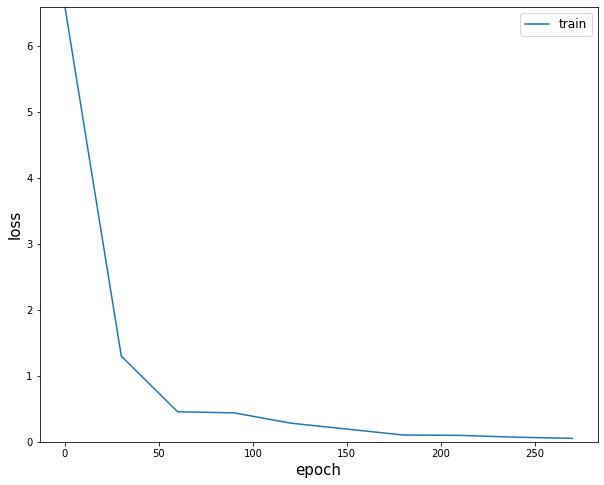

In [15]:
n_batch = 20
n_epoch = 300
n_prt = 30

sess = tf.Session()
sess.run(tf.global_variables_initializer())

loss_record_train = []
for epoch in range(n_epoch):
    train_x, train_y = train_batch_maker(n_batch)
    sess.run(optm, feed_dict = {x: train_x, y: train_y})

    if epoch % n_prt == 0:        
        c = sess.run(loss, feed_dict = {x: train_x, y: train_y})
        loss_record_train.append(c)
        print ("Epoch : {}".format(epoch))
        print ("Cost : {}".format(c))
        
plt.figure(figsize = (10,8))
plt.plot(np.arange(len(loss_record_train))*n_prt, loss_record_train, label = 'train')
plt.xlabel('epoch', fontsize = 15)
plt.ylabel('loss', fontsize = 15)
plt.legend(fontsize = 12)
plt.ylim([0, np.max(loss_record_train)])
plt.show()

In [1]:
my_pred = sess.run(pred, feed_dict = {x: test_imgs})
my_pred = np.argmax(my_pred, axis = 1)

labels = np.argmax(test_labels, axis = 1)

accr = np.mean(np.equal(my_pred, labels))
print("Accuracy : {}%".format(accr*100))

NameError: ignored

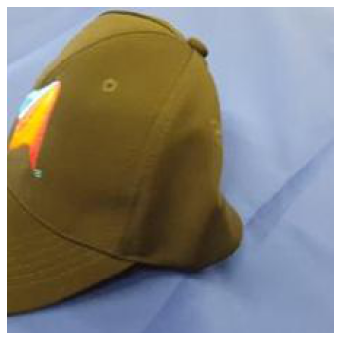

Prediction : Hat
Probability : [0.97 0.03 0.   0.   0.  ]


In [ ]:
test_x, test_y = test_batch_maker(1)
logits = sess.run(tf.nn.softmax(pred), feed_dict = {x: test_x.reshape(-1, 224, 224, 3)})
predict = np.argmax(logits)

plt.figure(figsize = (6,6))
plt.imshow(test_x.reshape(224, 224, 3))
plt.axis('off')
plt.show()

np.set_printoptions(precision = 2, suppress = True)
print('Prediction : {}'.format(Dict[predict]))
print('Probability : {}'.format(logits.ravel()))